#  Capstone project 2  --- Spotify recommendation engine 

## Problem Statement : Recommend the n number of songs to the base user :
### i) Based on their closest users behaviour.
### ii) Based on the number of songs heard by the user.

## Importing libraries

In [1]:
# Data handling Libraries
import pandas as pd
import numpy as np
from collections import OrderedDict
from pandas import DataFrame

# Importing Data Visualizing libraries
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import seaborn as sns

# Statistics Library
import scipy.stats as sci

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Machine learning libraries
from sklearn.linear_model import Ridge,Lasso
from sklearn.ensemble import AdaBoostRegressor , RandomForestRegressor , GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR 


 

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors



#Importing Validation Metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error


## Loading the dataset and convert into dataframe

In [2]:
df = pd.read_csv("spotify.xls",index_col=[0])
df.head()

,song_1,song_2,song_3,song_4,song_5,song_6,song_7,song_8,song_9,song_10,...,song_4991,song_4992,song_4993,song_4994,song_4995,song_4996,song_4997,song_4998,song_4999,song_5000
user_1,2,2,8,8,13,1,4,9,1,2,...,14,2,14,1,9,0,11,6,14,7
user_2,13,5,5,5,12,8,10,10,2,2,...,10,6,11,1,1,5,12,8,3,0
user_3,3,9,2,8,0,1,11,7,3,7,...,9,5,7,15,12,13,14,5,0,14
user_4,2,6,7,8,14,0,12,7,8,1,...,9,15,9,14,10,6,11,13,6,0
user_5,11,12,8,6,13,7,0,7,3,13,...,12,14,11,11,11,7,3,6,11,7


In [3]:
df.shape

(1000, 5000)

## Matrix Factorization

In [4]:
X = df.values  # Converted df into array / Sparse Matrix
X

array([[ 2,  2,  8, ...,  6, 14,  7],
       [13,  5,  5, ...,  8,  3,  0],
       [ 3,  9,  2, ...,  5,  0, 14],
       ...,
       [ 6,  2,  1, ..., 13,  6, 13],
       [ 7,  0,  8, ..., 11,  9, 12],
       [ 6, 15,  0, ..., 15,  4,  5]], dtype=int64)

In [5]:
from sklearn.decomposition import NMF # Non Negative Matrix Factorisation
nmf = NMF(n_components=100,max_iter=1000,random_state=200)

# Matrix 1 = 1000 * 200
# Matrix 2 = 200*5000


In [6]:
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=1000,
    n_components=100, random_state=200, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [7]:
user_matrix = nmf.transform(X)

In [8]:
user_matrix.shape

(1000, 100)

In [9]:
song_matrix = nmf.components_.T
song_matrix.shape

(5000, 100)

In [10]:
user_matrix

array([[0.03041152, 0.        , 6.03735754, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.10450949, 0.        , ..., 0.        , 1.51397869,
        0.        ],
       [0.        , 3.09227919, 0.        , ..., 0.62299824, 0.        ,
        0.        ],
       ...,
       [0.        , 1.26239448, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.11442141, 3.90306648, 0.5963574 , ..., 0.        , 0.51928477,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.32054707, 0.        ,
        0.        ]])

In [11]:
song_matrix

array([[0.29227977, 0.29155378, 0.23095434, ..., 0.02158349, 0.        ,
        0.042259  ],
       [0.2201218 , 0.        , 0.        , ..., 0.        , 0.52120311,
        0.16391248],
       [0.        , 0.16101005, 0.        , ..., 0.22639116, 0.26109955,
        0.14051861],
       ...,
       [0.        , 0.29521502, 0.02888085, ..., 0.31876971, 0.2938576 ,
        0.2803698 ],
       [0.21569302, 0.10762248, 0.04239307, ..., 0.17080385, 0.03336278,
        0.28784931],
       [0.10459146, 0.24942716, 0.12342307, ..., 0.31145263, 0.17757793,
        0.22799469]])

## Steps in building recommendation :
1. Consider recommending songs to user 1
2. Find the euclidean distance or direct distance between user1 and all 999 users
3. Find out top 10 songs heard by the closest five users.
4. Recommending songs to user 1


## i) Using closest five users behaviour recommendation

### Step :1 Calculating direct distance:

In [12]:

def caldist(u1,u2):
    return pow(sum([pow(u1[x]-u2[x],2) for x in range(len(u1))]),0.5)


In [13]:
caldist(user_matrix[0],user_matrix[602])



16.691475972311192

### Step:2  Calculating distance from base user and all other users:

In [14]:
## Step : 2 Calculating distance from base user and all other users:
def distfromuser(wuser,user_matrix):
    import sys
    distance = []
    for i in range(len(user_matrix)):
        if wuser!= i:
            distance.append(caldist(user_matrix[wuser],user_matrix[i]))
        else:
            distance.append(sys.float_info.max)
    return distance


In [15]:
distuser1 = distfromuser(0,user_matrix)

In [16]:
distuser1

[1.7976931348623157e+308,
 16.40023520051006,
 15.537635020053532,
 14.639473650944137,
 14.00754490256619,
 13.97132082169655,
 14.458815384019875,
 15.439919100639933,
 15.365881759494002,
 14.750585290155577,
 13.757119242936719,
 13.43628155682533,
 14.234045963373617,
 14.6737814273424,
 15.645889217375041,
 15.713779804128109,
 14.174156010302154,
 14.151881524527282,
 14.127183453423001,
 14.872031632408873,
 14.423506733665775,
 15.565049449616957,
 14.662728068093031,
 13.844900901929332,
 15.712321900581676,
 15.466713620926093,
 15.824884352502732,
 15.208346654822414,
 15.042134139507336,
 14.897609730665527,
 14.087798476450345,
 14.538880224154314,
 14.77067073317268,
 14.949431884063038,
 13.641154833850534,
 14.249887985667046,
 14.697785816841307,
 16.97115950067046,
 14.722157373020192,
 14.574156282216629,
 12.134159028442259,
 15.540593519980174,
 15.927465372786699,
 13.992981665810861,
 13.674354874089165,
 15.547516231846972,
 14.240597471376711,
 14.120008692113

In [17]:
user_index  = np.argsort(distuser1)[0:5] # Automatically sort and return the indices of the sorted elements for a given length
user_index


array([313, 379, 174, 882, 687], dtype=int64)

### Step : 3 Finding songs heard by closest users

In [18]:

for i in user_index:
    print('Songs heard by the user in index ',i,' are')
    temp = pd.DataFrame(df.iloc[i])
    print(temp[temp.values != 0].index)

Songs heard by the user in index  313  are
Index(['song_1', 'song_2', 'song_3', 'song_4', 'song_5', 'song_6', 'song_7',
       'song_8', 'song_10', 'song_11',
       ...
       'song_4991', 'song_4992', 'song_4993', 'song_4994', 'song_4995',
       'song_4996', 'song_4997', 'song_4998', 'song_4999', 'song_5000'],
      dtype='object', length=4690)
Songs heard by the user in index  379  are
Index(['song_1', 'song_2', 'song_3', 'song_4', 'song_5', 'song_6', 'song_7',
       'song_8', 'song_10', 'song_11',
       ...
       'song_4990', 'song_4991', 'song_4993', 'song_4994', 'song_4995',
       'song_4996', 'song_4997', 'song_4998', 'song_4999', 'song_5000'],
      dtype='object', length=4674)
Songs heard by the user in index  174  are
Index(['song_1', 'song_2', 'song_3', 'song_4', 'song_5', 'song_6', 'song_7',
       'song_8', 'song_9', 'song_10',
       ...
       'song_4991', 'song_4992', 'song_4993', 'song_4994', 'song_4995',
       'song_4996', 'song_4997', 'song_4998', 'song_4999', 

#### Recommending top 5 songs:

In [19]:

def get_top5_songs(user_index,df):
    temp_df = df.iloc[user_index]  # Contains all the values coming from index
    dict_1 = temp_df.max().to_dict()  # it gives the song which are heard max 
    sorted_dict = sorted(dict_1.items(),key= lambda keyvalue:(keyvalue[1],keyvalue[0]),reverse=True)[0:5]
    return[x[0] for x in sorted_dict]

In [20]:
get_top5_songs(user_index,df)

['song_998', 'song_996', 'song_991', 'song_990', 'song_988']

##  ii) Using K Means for Recommendation based on number of songs heard by the user

In [21]:
from sklearn.cluster import KMeans

In [22]:
withincluster_mse = {}
for k in range(1,50):
    kmeans = KMeans(n_clusters=k,max_iter=200).fit(song_matrix)
    withincluster_mse[k] = kmeans.inertia_                     #this is MSE in kmeans

In [23]:
withincluster_mse

{1: 14055.597631044977,
 2: 13892.039458183379,
 3: 13770.032580631474,
 4: 13680.742766928835,
 5: 13599.030488883529,
 6: 13532.491648225798,
 7: 13471.028958125427,
 8: 13414.417352863242,
 9: 13381.75641438299,
 10: 13341.783348004583,
 11: 13301.701087083993,
 12: 13269.903282474803,
 13: 13230.088654399711,
 14: 13202.984460834268,
 15: 13184.581895876227,
 16: 13157.464553456088,
 17: 13133.002217327588,
 18: 13109.41920279072,
 19: 13096.596548285255,
 20: 13072.046148026162,
 21: 13052.440792291047,
 22: 13032.178915453458,
 23: 13007.616948603207,
 24: 12997.487791621448,
 25: 12976.107062783105,
 26: 12961.646515483306,
 27: 12957.544910127996,
 28: 12946.037023896422,
 29: 12920.859011462635,
 30: 12901.885158126985,
 31: 12893.87633634855,
 32: 12880.325475051244,
 33: 12863.41372666996,
 34: 12856.98106218438,
 35: 12844.342682656512,
 36: 12817.316597576253,
 37: 12823.946474054059,
 38: 12797.332089851505,
 39: 12796.080069457104,
 40: 12784.547269011606,
 41: 12777.685

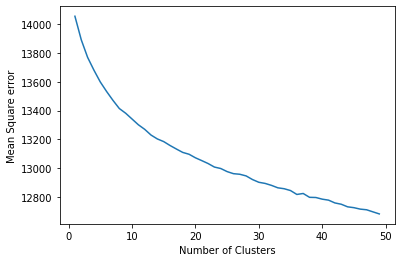

In [24]:
plt.figure()
plt.plot(list(withincluster_mse.keys()),list(withincluster_mse.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Square error')
plt.show()

### Recommending songs from songs point of view ie., no of times the song is played and not using the closeness of the user:


In [25]:
def returnsongs_in_cluster(df,data_n,n_cluster,song_matrix,song_name,n_recommendations):
    kmeans = KMeans(n_clusters=n_cluster,max_iter=200).fit(song_matrix)     # makes cluster of the songs(clusters will happen on basis of no of times the song heard)
    index_in_song = df.columns.to_list().index(song_name)               # Gets the index of the base song
    
    song_vector = song_matrix[index_in_song]                                # Copies the listening values of the base song
    
    all_songsin_cluster = list(kmeans.predict(song_matrix))                 # Creating the clusters of the song
    
    songs_in_selected_cluster = [x for x in range(len(all_songsin_cluster)) if all_songsin_cluster[x] == kmeans.predict([song_vector])]
                                                                            # Checks the listening values of the base song and the songs inside the cluster to identify which cluster my song belongs to 
    
    song_cluster = song_matrix[songs_in_selected_cluster]                   # gets the song name from the song matrix on the basis
    
    knn = NearestNeighbors(n_neighbors=n_recommendations)                   # fits knn algorithm on basis number of songs to be recommended
    knn.fit(song_cluster)                                                   #Identifying the neighbors on the basis of clusters
    recommend_songs = knn.kneighbors([song_matrix[index_in_song]])[1]       # Nearest neighbor songs
    return data_n[recommend_songs]                                          # returning songs name
    
    

In [26]:
returnsongs_in_cluster(df,df.columns,12,song_matrix,'song_5',10)

Index([['song_1', 'song_363', 'song_343', 'song_165', 'song_210', 'song_3', 'song_304', 'song_96', 'song_244', 'song_168']], dtype='object')